<h1>Più liberi o più felici?  Un'Analisi Globale dal 2015 al 2019</h1>
<p>Indagando le Relazioni e le Variazioni di Percezione tra le Nazioni nel Tempo</p>

<h2>Overview</h2>

Tramite questo studio cerchiamo di dare una risposta alle seguenti domande relative ai concetti di <i>felicità</i> e <i>libertà</i>:

<ul>
    <li>Cos'è la felicità? Cos'è la libertà?</li>
    <li>Cosa le caratterizza?</li>
    <li>Che aspetti del benessere personale hanno in comune?</li>
    <li>Come vengono percepite dalle nazioni del mondo?</li>
</ul>

In [141]:
#import library

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from sklearn.preprocessing import StandardScaler

import warnings
from shapely.errors import ShapelyDeprecationWarning


<h2>Data Sources</h2>

Per l'analisi sono stati presi in considerazione i seguenti dataset con riferimento agli anni 2015-2019:

<ul>
    <li><a href="https://www.kaggle.com/datasets/gsutters/the-human-freedom-index">Human Freedom</a></li> 
    che offre una panoramica mondiale di come le nazioni percepiscono il senso di libertà
    <li><a href="https://www.kaggle.com/datasets/unsdsn/world-happiness">World Happiness Report</a></li> Che offre una panoramica mondiale di come le nazioni percepiscono il senso di felicità
</ul>

In [2]:
#import dataset

#human_freedom
hf22 = pd.read_csv('dataset/human_freedom_index/hfi_cc_2022.csv')

#world_happiness
wh15 = pd.read_csv('dataset/world_happiness_report/2015.csv')
wh16 = pd.read_csv('dataset/world_happiness_report/2016.csv')
wh17 = pd.read_csv('dataset/world_happiness_report/2017.csv')
wh18 = pd.read_csv('dataset/world_happiness_report/2018.csv')
wh19 = pd.read_csv('dataset/world_happiness_report/2019.csv')

# geospatial data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# DATA CLEANING

## human_fredom_index cleaning

In [3]:
hf22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Columns: 141 entries, year to ef_rank
dtypes: float64(133), int64(3), object(5)
memory usage: 3.7+ MB


In [4]:
#Since assembly is a subarea of ​​association, the columns were renamed correctly
hf22.columns = ['pf_association_assembly' + c.split('pf_assembly', 1)[1] if c.startswith('pf_assembly') else c for c in hf22.columns]
hf22['pf_association'] = hf22['pf_association_assembly']

hf22.rename(columns = {'countries':'country'}, inplace = True) 

In [5]:
#get all rows between [2015-2019]
freedom_data = hf22[(hf22['year'] >= 2015) & (hf22['year'] <= 2019)]
freedom_data.reset_index(inplace=True)

In [6]:
#get only relevant columns
principal_columns = [c for c in freedom_data.columns.values if c.count('_') <= 1]
freedom_data = freedom_data[principal_columns]
#the columns not of interest are eliminated
freedom_data = freedom_data.drop(['index', 'hf_rank', 'hf_quartile', 'pf_rank', 'ef_rank'], axis=1)
freedom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            825 non-null    int64  
 1   country         825 non-null    object 
 2   region          825 non-null    object 
 3   hf_score        810 non-null    float64
 4   pf_rol          820 non-null    float64
 5   pf_ss           825 non-null    float64
 6   pf_movement     825 non-null    float64
 7   pf_religion     825 non-null    float64
 8   pf_expression   825 non-null    float64
 9   pf_identity     825 non-null    float64
 10  pf_score        810 non-null    float64
 11  ef_government   813 non-null    float64
 12  ef_gender       819 non-null    float64
 13  ef_legal        813 non-null    float64
 14  ef_money        810 non-null    float64
 15  ef_trade        810 non-null    float64
 16  ef_regulation   810 non-null    float64
 17  ef_score        810 non-null    flo

In [7]:
freedom_data.filter(like='ef_').describe()

,ef_government,ef_gender,ef_legal,ef_money,ef_trade,ef_regulation,ef_score
count,813.000000,819.000000,813.000000,810.000000,810.000000,810.000000,810.000000
mean,6.740107,0.853193,5.317495,8.310200,7.024498,6.998239,6.880407
std,1.121998,0.184793,1.580576,1.439566,1.417460,1.101405,0.991370
min,2.380000,0.294118,2.123833,0.944935,1.002673,2.497275,2.720000
25%,5.937787,0.823529,4.296775,7.282118,6.063888,6.431694,6.205000
50%,6.776254,0.941176,5.137943,8.687929,7.166840,7.097546,7.030000
75%,7.550400,1.000000,6.316099,9.436710,8.220009,7.763873,7.657500
max,9.287349,1.000000,8.921169,9.904163,9.555910,9.429423,9.010000


<p>'ef_gender' ha un andamento anomalo. 
I suoi valori oscillano tra [0-1] piuttosto che tra [0-10].
La media tra tutti i valori delle colonne relative all'analisi della libertà, non restisce ef_score se presa in considerazione la colonna ef_gender.

Per questi motivi è stato scelto di eliminare la colonna 
</p>

In [8]:
freedom_data = freedom_data.drop(['ef_gender'], axis=1)

In [9]:
#get info about principal columns in freedom_data dataframe
freedom_data[["hf_score", "pf_score", "ef_score"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hf_score  810 non-null    float64
 1   pf_score  810 non-null    float64
 2   ef_score  810 non-null    float64
dtypes: float64(3)
memory usage: 19.5 KB


In [10]:
freedom_data[freedom_data[["hf_score", "pf_score", "ef_score"]].isna().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 199 to 800
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            15 non-null     int64  
 1   country         15 non-null     object 
 2   region          15 non-null     object 
 3   hf_score        0 non-null      float64
 4   pf_rol          15 non-null     float64
 5   pf_ss           15 non-null     float64
 6   pf_movement     15 non-null     float64
 7   pf_religion     15 non-null     float64
 8   pf_expression   15 non-null     float64
 9   pf_identity     15 non-null     float64
 10  pf_score        0 non-null      float64
 11  ef_government   3 non-null      float64
 12  ef_legal        3 non-null      float64
 13  ef_money        0 non-null      float64
 14  ef_trade        0 non-null      float64
 15  ef_regulation   0 non-null      float64
 16  ef_score        0 non-null      float64
 17  pf_association  15 non-null     float64

The columns "hf_score", "pf_score", "ef_score" are significant columns. Therefore, it was decided to eliminate the rows that have the fields of the 3 columns set to nan

In [11]:
freedom_data.dropna(subset=["hf_score", "pf_score", "ef_score"], how='any', inplace=True)
freedom_data[["hf_score", "pf_score", "ef_score"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 810 entries, 0 to 824
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hf_score  810 non-null    float64
 1   pf_score  810 non-null    float64
 2   ef_score  810 non-null    float64
dtypes: float64(3)
memory usage: 25.3 KB


In [12]:
freedom_data.head(5)

,year,country,region,hf_score,pf_rol,pf_ss,pf_movement,pf_religion,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
0,2019,Albania,Eastern Europe,8.07,4.892466,9.350083,9.868750,9.737500,6.248600,8.75,8.27,7.914393,5.258757,9.826979,8.230921,7.700885,7.79,9.051458
1,2019,Algeria,Middle East & North Africa,5.08,4.890457,8.952936,5.927500,5.236667,4.586654,2.50,5.24,4.493472,4.142208,7.287095,2.549231,5.840164,4.86,4.561065
2,2019,Angola,Sub-Saharan Africa,5.96,3.534740,8.463164,7.617917,6.736667,5.500711,6.25,6.25,8.052209,3.667891,4.665603,5.406230,5.974672,5.55,5.631134
3,2019,Argentina,Latin America & the Caribbean,7.33,5.574289,8.404363,9.760833,9.859375,8.205444,10.00,8.68,6.547886,4.797548,3.879031,5.975559,5.994265,5.44,8.959514
4,2019,Armenia,Caucasus & Central Asia,8.32,7.287006,9.264917,9.844167,8.338542,7.617444,8.75,8.56,7.769871,6.250506,9.519745,8.525586,7.819774,7.98,8.817963


In [13]:
freedom_data[['hf_score', 'pf_score', 'ef_score']].describe()

,hf_score,pf_score,ef_score
count,810.000000,810.000000,810.000000
mean,7.050062,7.170309,6.880407
std,1.295606,1.693884,0.991370
min,3.150000,2.080000,2.720000
25%,6.142500,5.812500,6.205000
50%,7.120000,7.440000,7.030000
75%,8.097500,8.537500,7.657500
max,9.200000,9.690000,9.010000


## happiness_report cleaning

In [14]:
#Uniform columns between dataset

#drop columns 
wh15 = wh15.drop(columns=['Region', 'Standard Error', 'Dystopia Residual'], axis=1)
wh16 = wh16.drop(columns=['Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Dystopia Residual'], axis=1)
wh17 = wh17.drop(columns=['Whisker.high', 'Whisker.low', 'Dystopia.Residual'], axis=1)


#rename columns
wh19 = wh19.rename(columns={"Country or region": "country",
                     "Overall rank": "happiness_rank", 
                     "Score": "happiness_score",
                     "GDP per capita": "economy",
                     "Social support": "family",
                     "Healthy life expectancy": "health",
                     "Freedom to make life choices": "freedom",
                     "Perceptions of corruption": "trust",
                     "Generosity": "generosity"
                     })

wh18 = wh18.rename(columns={"Country or region": "country",
                     "Overall rank": "happiness_rank", 
                     "Score": "happiness_score",
                     "GDP per capita": "economy",
                     "Social support": "family",
                     "Healthy life expectancy": "health",
                     "Freedom to make life choices": "freedom",
                     "Perceptions of corruption": "trust",
                     "Generosity": "generosity"
                     })

wh17 = wh17.rename(columns={"Country": "country",
                     "Happiness.Rank": "happiness_rank", 
                     "Happiness.Score": "happiness_score",
                     "Economy..GDP.per.Capita.": "economy",
                     "Family": "family",
                     "Health..Life.Expectancy.": "health",
                     "Freedom": "freedom",
                     "Trust..Government.Corruption.": "trust",
                     "Generosity": "generosity"
                     })

wh16 = wh16.rename(columns={"Country": "country",
                     "Happiness Rank": "happiness_rank", 
                     "Happiness Score": "happiness_score",
                     "Economy (GDP per Capita)": "economy",
                     "Family": "family",
                     "Health (Life Expectancy)": "health",
                     "Freedom": "freedom",
                     "Trust (Government Corruption)": "trust",
                     "Generosity": "generosity"
                     })

wh15 = wh15.rename(columns={"Country": "country",
                     "Happiness Rank": "happiness_rank", 
                     "Happiness Score": "happiness_score",
                     "Economy (GDP per Capita)": "economy",
                     "Family": "family",
                     "Health (Life Expectancy)": "health",
                     "Freedom": "freedom",
                     "Trust (Government Corruption)": "trust",
                     "Generosity": "generosity"
                     })

#add column year for every dataframe
wh15['year'] = 2015
wh16['year'] = 2016
wh17['year'] = 2017
wh18['year'] = 2018
wh19['year'] = 2019

frames = [wh15, wh16, wh17, wh18, wh19]
happiness_data = pd.concat(frames)

In [15]:
happiness_data.info()
print("Unique countries: ", happiness_data.country.nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 782 entries, 0 to 155
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          782 non-null    object 
 1   happiness_rank   782 non-null    int64  
 2   happiness_score  782 non-null    float64
 3   economy          782 non-null    float64
 4   family           782 non-null    float64
 5   health           782 non-null    float64
 6   freedom          782 non-null    float64
 7   trust            781 non-null    float64
 8   generosity       782 non-null    float64
 9   year             782 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 67.2+ KB
Unique countries:  170


In [16]:
happiness_data = happiness_data.drop(columns=['happiness_rank'])

Rendiamo i dataframe allineati per il counrty rispetto al dataset world

In [17]:
print(freedom_data[~freedom_data['country'].isin(world['name'])]['country'].unique())
print('')
print(happiness_data[~happiness_data['country'].isin(world['name'])]['country'].unique())

['Bahamas, The' 'Bahrain' 'Barbados' 'Bosnia and Herzegovina'
 'Brunei Darussalam' 'Cabo Verde' 'Central African Republic' 'Comoros'
 'Congo, Dem. Rep.' 'Congo, Rep.' "Cote d'Ivoire" 'Czech Republic'
 'Dominican Republic' 'Egypt, Arab Rep.' 'Eswatini' 'Gambia, The'
 'Hong Kong SAR, China' 'Iran, Islamic Rep.' 'Korea, Rep.'
 'Kyrgyz Republic' 'Lao PDR' 'Malta' 'Mauritius' 'North Macedonia'
 'Russian Federation' 'Seychelles' 'Singapore' 'Slovak Republic'
 'Syrian Arab Republic' 'United States' 'Venezuela, RB' 'Yemen, Rep.']

['United States' 'Singapore' 'Czech Republic' 'Malta' 'Bahrain'
 'North Cyprus' 'Mauritius' 'Hong Kong' 'Somaliland region'
 'Bosnia and Herzegovina' 'Dominican Republic' 'Swaziland'
 'Palestinian Territories' 'Congo (Kinshasa)' 'Congo (Brazzaville)'
 'Comoros' 'Central African Republic' 'Ivory Coast' 'Somaliland Region'
 'South Sudan' 'Taiwan Province of China' 'Hong Kong S.A.R., China'
 'Trinidad & Tobago' 'Northern Cyprus' 'North Macedonia']


In [18]:
happiness_data['country'] = happiness_data['country'].replace(['Bosnia and Herzegovina'], 'Bosnia and Herz.')
happiness_data['country'] = happiness_data['country'].replace(['Central African Republic'], 'Central African Rep.')
happiness_data['country'] = happiness_data['country'].replace(['Congo (Brazzaville)'], 'Congo')
happiness_data['country'] = happiness_data['country'].replace(['Congo (Kinshasa)'], 'Dem. Rep. Congo')
happiness_data['country'] = happiness_data['country'].replace(['Czech Republic'], 'Czechia')
happiness_data['country'] = happiness_data['country'].replace(['Dominican Republic'], 'Dominican Rep.')
happiness_data['country'] = happiness_data['country'].replace(['Hong Kong S.A.R., China'], 'Hong Kong')
happiness_data['country'] = happiness_data['country'].replace(['Ivory Coast'], "Côte d'Ivoire")
happiness_data['country'] = happiness_data['country'].replace(['North Cyprus'], 'Cyprus')
happiness_data['country'] = happiness_data['country'].replace(['Northern Cyprus'], 'Cyprus')
happiness_data['country'] = happiness_data['country'].replace(['North Macedonia'], 'Macedonia')
happiness_data['country'] = happiness_data['country'].replace(['Palestinian Territories'], 'Palestine')
happiness_data['country'] = happiness_data['country'].replace(['Somaliland region'], 'Somaliland Region')
happiness_data['country'] = happiness_data['country'].replace(['South Sudan'], 'S. Sudan')
happiness_data['country'] = happiness_data['country'].replace(['Swaziland'], 'eSwatini')
happiness_data['country'] = happiness_data['country'].replace(['Taiwan Province of China'], 'Taiwan')
happiness_data['country'] = happiness_data['country'].replace(['Trinidad & Tobago'], 'Trinidad and Tobago')
happiness_data['country'] = happiness_data['country'].replace(['United States'], 'United States of America')

freedom_data['country'] = freedom_data['country'].replace(['Bahamas, The'], 'Bahamas')
freedom_data['country'] = freedom_data['country'].replace(['Bosnia and Herzegovina'], 'Bosnia and Herz.')
freedom_data['country'] = freedom_data['country'].replace(['Central African Republic'], 'Central African Rep.')
freedom_data['country'] = freedom_data['country'].replace(['Congo, Dem. Rep.'], 'Dem. Rep. Congo')
freedom_data['country'] = freedom_data['country'].replace(['Congo, Rep.'], 'Congo')
freedom_data['country'] = freedom_data['country'].replace(["Cote d'Ivoire"], "Côte d'Ivoire")
freedom_data['country'] = freedom_data['country'].replace(['Czech Republic'], 'Czechia')
freedom_data['country'] = freedom_data['country'].replace(['Dominican Republic'], 'Dominican Rep.')
freedom_data['country'] = freedom_data['country'].replace(['Egypt, Arab Rep.'], 'Egypt')
freedom_data['country'] = freedom_data['country'].replace(['Eswatini'], 'eSwatini')
freedom_data['country'] = freedom_data['country'].replace(['Gambia, The'], 'Gambia')
freedom_data['country'] = freedom_data['country'].replace(['Hong Kong SAR, China'], 'Hong Kong')
freedom_data['country'] = freedom_data['country'].replace(['Iran, Islamic Rep.'], 'Iran')
freedom_data['country'] = freedom_data['country'].replace(['Korea, Rep.'], 'South Korea')
freedom_data['country'] = freedom_data['country'].replace(['Kyrgyz Republic'], 'Kyrgyzstan')
freedom_data['country'] = freedom_data['country'].replace(['Lao PDR'], 'Laos')
freedom_data['country'] = freedom_data['country'].replace(['North Macedonia'], 'Macedonia')
freedom_data['country'] = freedom_data['country'].replace(['Slovak Republic'], 'Slovakia')
freedom_data['country'] = freedom_data['country'].replace(['Syrian Arab Republic'], 'Syria')
freedom_data['country'] = freedom_data['country'].replace(['Venezuela, RB'], 'Venezuela')
freedom_data['country'] = freedom_data['country'].replace(['United States'], 'United States of America')
freedom_data['country'] = freedom_data['country'].replace(['Yemen, Rep.'], 'Yemen')

In [19]:
happy_free = pd.merge(happiness_data, freedom_data,  how='inner', left_on=['country','year'], right_on = ['country','year']).sort_values('country')

In [20]:
happy_free.sample(5)

,country,happiness_score,economy,family,health,freedom,trust,generosity,year,region,...,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
12,Austria,7.200,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,2015,Western Europe,...,8.935018,10.000,9.38,5.614036,8.255694,9.616600,8.370503,7.532586,7.88,9.432917
580,Liberia,3.495,0.07600,0.85800,0.26700,0.41900,0.03000,0.20600,2018,Sub-Saharan Africa,...,7.184633,3.265,7.00,6.631366,4.261137,8.480125,5.778353,5.375209,6.11,8.997731
484,Italy,6.000,1.26400,1.50100,0.94600,0.28100,0.02800,0.13700,2018,Western Europe,...,8.260708,10.000,9.01,5.765928,6.477564,9.346609,8.705109,7.730278,7.61,9.611875
715,Ethiopia,4.286,0.33600,1.03300,0.53200,0.34400,0.10000,0.20900,2019,Sub-Saharan Africa,...,4.144949,4.620,5.67,6.227259,4.454864,5.948537,5.640115,6.842296,5.82,5.835231
684,Benin,4.883,0.39300,0.43700,0.39700,0.34900,0.08200,0.17500,2019,Sub-Saharan Africa,...,6.796733,7.895,7.67,7.963812,4.574790,7.324091,6.181736,7.240735,6.66,8.154815


In [21]:
happiness_data[happiness_data.country == 'Russia']

,country,happiness_score,economy,family,health,freedom,trust,generosity,year
63,Russia,5.716,1.137640,1.236170,0.669260,0.366790,0.030050,0.001990,2015
55,Russia,5.856,1.232280,1.052610,0.589910,0.326820,0.035860,0.027360,2016
48,Russia,5.963,1.281778,1.469282,0.547349,0.373783,0.032963,0.052264,2017
58,Russia,5.810,1.151000,1.479000,0.599000,0.399000,0.025000,0.065000,2018
67,Russia,5.648,1.183000,1.452000,0.726000,0.334000,0.031000,0.082000,2019


<h1>Libertà e Felicità</h1>
<p>Cosa sono? Di cosa sono fatte?</p>

<h2>Libertà e Felicità</h2>

<p>I dataset selezionati, contengono i risultati di questionari, sottoposti alla maggior parte delle nazioni mondiali, inerenti alle sensazioni che si percepiscono rispetto alla libertà e alla felicità.</p>
<p>Entrambi i dataset resistuiscono un valore globale, misurabile in una scala da 0 a 10, che indica la percezione che ha una specifica nazione, di libertà e felicità.</p>
<p>Ogni dataset ha inoltre al proprio interno, una serie di variabili che rappresentano una valutazione rispetto ai macroambiti che influenzano la libertà e la felicità.</p>

<h2>Libertà e Felicità - Distribuzione</h2>

<p>Per meglio capire i dati contenuti nei dataset andremo ad aiutarci con dei grafici che ci chiariranno i seguenti aspetti:</p>

<ul>
<li>Come si distribuiscono Libertà e Felicità</li>
<li>Da cosa sono influenzate Libertà e Felicità</li>
</ul>

In [22]:
def show_boxplot():
    plt.figure(figsize=(6, 6))
    boxplot = plt.boxplot([happy_free['hf_score'], happy_free['happiness_score']], patch_artist=True, labels=['libertà', 'felicità'], widths=0.7)

    boxplot['boxes'][0].set(facecolor='#FF6666')
    boxplot['boxes'][1].set(facecolor='#98FB98')

    for median in boxplot['medians']:
        median.set(color='black')

    plt.title('Distribuzioni delle variabili di libertà e felicità')
    #plt.ylabel('')

    plt.show()

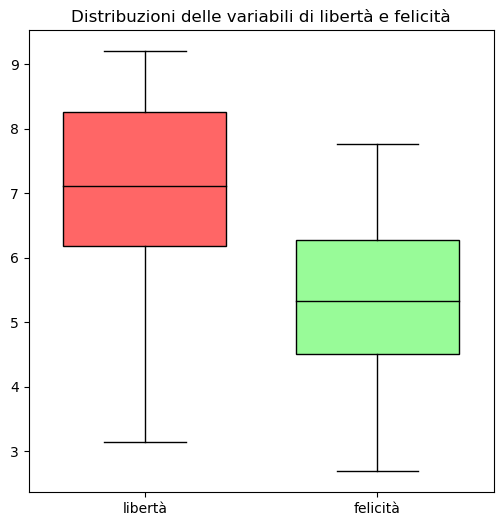

In [23]:
show_boxplot()

<h2>Di cosa è fatta la libertà?</h2>

In [ ]:
data = {'pf_rol': 'rule&role',
        'pf_ss': 'security&safety',
        'pf_movement': 'movement',
        'pf_religion': 'religion',
        'pf_expression': 'expression and information',
        'pf_identity': 'identity and relationship',
        'pf_score': 'personal freedom score',
        'ef_government': 'government',
        'ef_gender': 'gender',
        'ef_legal': 'legal system and property right',
        'ef_money': 'access to sound money',
        'ef_trade': 'freedom to trade internationally',
        'ef_regulation': 'regulation of credit and business',
        'ef_score': 'economic freedom score',
        'pf_association': 'association, assembly and civil society'}

In [24]:
#Calcolo la serie delle percentuali

freedom_mean = freedom_data.select_dtypes(include=['number']).mean()
freedom_mean = freedom_mean.drop(labels=['year'])

personal_freedom_columns = ['pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression', 'pf_identity', 'pf_association']
economic_freedom_columns = ['ef_government', 'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation']

total_human_freedom = freedom_mean[['pf_score', 'ef_score']].sum()
total_personal_freedom = freedom_mean[personal_freedom_columns].sum()
total_economic_freedom = freedom_mean[economic_freedom_columns].sum()


h_freedom_percentage = freedom_mean[['pf_score', 'ef_score']]/total_human_freedom
p_freedom_percentage = freedom_mean[personal_freedom_columns]/total_personal_freedom * h_freedom_percentage.pf_score
e_freedom_percentage = freedom_mean[economic_freedom_columns]/total_economic_freedom * h_freedom_percentage.ef_score

freedom_percentage = pd.concat([h_freedom_percentage, p_freedom_percentage, e_freedom_percentage]) * 100

In [25]:
#create pie plot
principal_values = freedom_percentage[['pf_score', 'ef_score']].values
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

detail_values = freedom_percentage[personal_freedom_columns + economic_freedom_columns].values
detail_labels = freedom_percentage[personal_freedom_columns + economic_freedom_columns].index

blue_colors = sns.color_palette("Blues", 7)
orange_colors = sns.color_palette("Oranges", 5)
colors = blue_colors + orange_colors


# Converti i colori in codice esadecimale
personal_colors = [sns.palettes.color_palette([color]).as_hex()[0] for color in blue_colors]
economic_colors = [sns.palettes.color_palette([color]).as_hex()[0] for color in blue_colors]

In [26]:
label_test = ['rule&rol', 'security&safety', 'movement', 'religion', 'expression and information',
       'identity and relationship', 'association, assembly and civil society', 'government', 'legal system and property right',
       'access to sound money', 'freedom to trade internationally', 'regulation of credit and business']

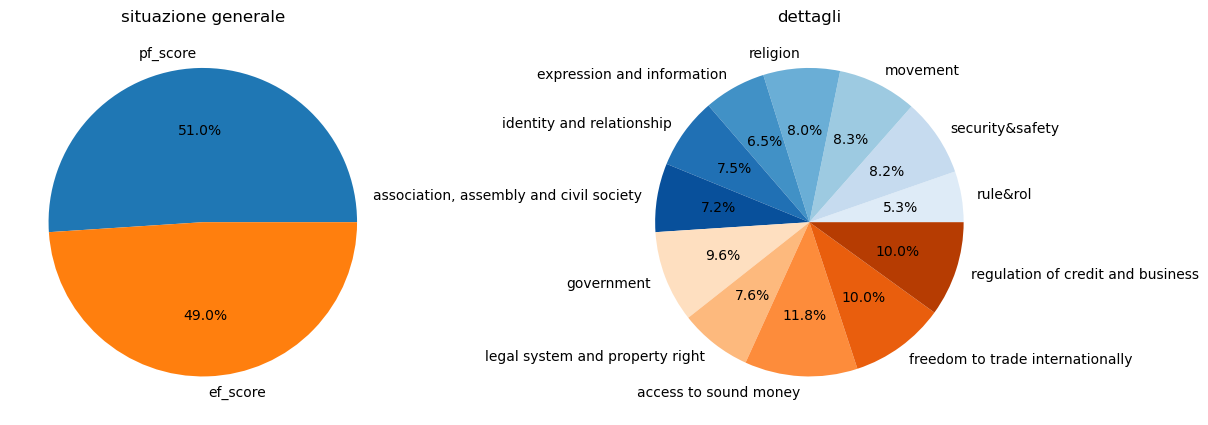

In [27]:
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
plt.title('situazione generale')

plt.subplot(1, 2, 2)
#plt.pie(detail_values, labels=detail_labels, colors=colors , autopct='%1.1f%%')
plt.pie(detail_values, labels=label_test, colors=colors , autopct='%1.1f%%')
plt.title('dettagli')


plt.tight_layout()

In [ ]:
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
plt.title('situazione generale')

plt.subplot(1, 2, 2)
plt.pie(detail_values, colors=colors , autopct='%1.1f%%')
plt.title('dettagli')

# Calcola i valori necessari per posizionare le etichette
angles = np.cumsum(detail_values / sum(detail_values) * 360)
mid_angles = (angles - 0.5 * detail_values / sum(detail_values) * 360) * np.pi / 180

# Aggiungi le etichette e le frecce
for angle, mid_angle, label in zip(angles, mid_angles, label_test):
    radius = 1.2
    x_arrow = radius * np.cos(mid_angle)
    y_arrow = radius * np.sin(mid_angle)
    plt.annotate(label, xy=(x_arrow, y_arrow), xytext=(2*np.cos(mid_angle), 2*np.sin(mid_angle)),
                 horizontalalignment='center', verticalalignment='center',
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.tight_layout()
plt.show()


In [ ]:
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
plt.title('situazione generale')

plt.subplot(1, 2, 2)
plt.pie(detail_values, labels=label_test, colors=colors , autopct='%1.1f%%')
plt.title('dettagli')

# Aggiungi la legenda per le parti del pie plot
plt.legend(label_test, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
for idx in detail_labels:
    #print(detail_labels)
    print(idx)
    print(data[idx])

<h2>Di cosa è fatta la felicità?</h2>

In [28]:
principal_columns = ['economy', 'family', 'health', 'freedom', 'trust', 'generosity']

happiness_mean = happiness_data[principal_columns].mean()
happiness_percentage = (happiness_mean / happiness_mean.sum()) * 100

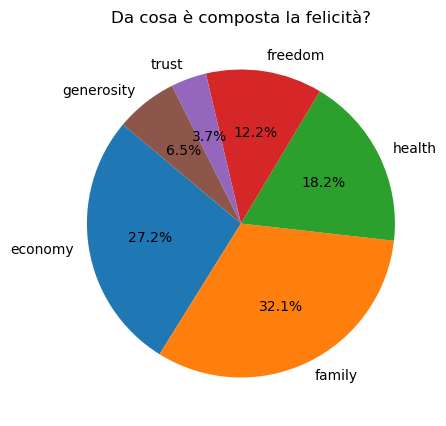

In [29]:
# Happyness pie plot
plt.figure(figsize=(5, 5))
plt.pie(happiness_percentage, labels=happiness_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Da cosa è composta la felicità?')
plt.show()

<h1>Libertà e Felicità: che relazione hanno?</h1>

<h2>Relazione tra felicità e libertà</h2>

<p>Di seguito andremo ad analizzare la relazione che c'è tra libertà e felicità.

A supporto dell'analisi verranno generati i seguenti grafici:
<ul>
    <li><b>Grafico a dispersione</b></li> che permetterà di valutare l'effettiva relazione tra felicità e libertà
    <li><b>Heatmap</b></li> che permetterà di valutare la relazione tra i componenti di felicità e libertà
</ul>
</p>

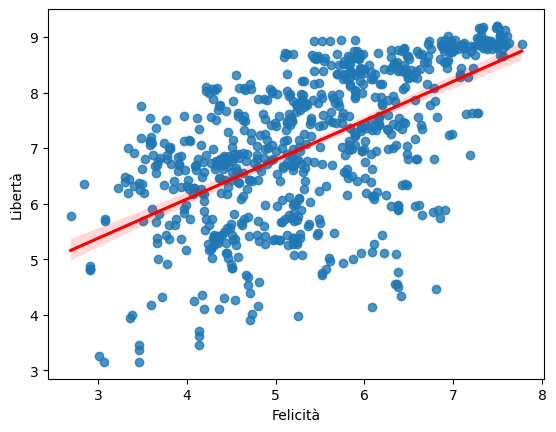

In [30]:
sns.regplot(data=happy_free, x="happiness_score", y="hf_score", order=1, line_kws=dict(color="r"))
plt.xlabel('Felicità')
plt.ylabel('Libertà')
plt.show()

In [31]:
coefficients = np.polyfit(happy_free.happiness_score, happy_free.hf_score, 1)
m, b = coefficients

y = {m}x + {b}

In [ ]:
plt.scatter(happy_free.happiness_score, happy_free.hf_score)
plt.plot(happy_free.happiness_score, m*happy_free.happiness_score + b, color='red', label='Regressione lineare')
#plt.xlabel('Felicità'), plt.ylabel('Libertà')
plt.title('scatterplot Felicità-Libertà')
plt.show()

<p>
Di seguito verranno mostrate le heatmap che rappresentano la correlazione tra
<ul>
    <li>felicità-libertà personale</li>
    <li>felicità-libertà economica</li>
</ul>
</p>

In [32]:
heatmap_happy_pfreedom = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'pf_score','pf_association']]  

heatmap_happy_efreedom = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity', 'ef_government', 'ef_legal', 'ef_money',
       'ef_trade', 'ef_regulation']]  

corr_happy_pfreedom = heatmap_happy_pfreedom.corr()
corr_happy_efreedom = heatmap_happy_efreedom.corr()

In [33]:
heatmap_columns = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'pf_score', 'ef_government', 'ef_legal', 'ef_money',
       'ef_trade', 'ef_regulation', 'pf_association']]  


corr_matrix = heatmap_columns.corr()

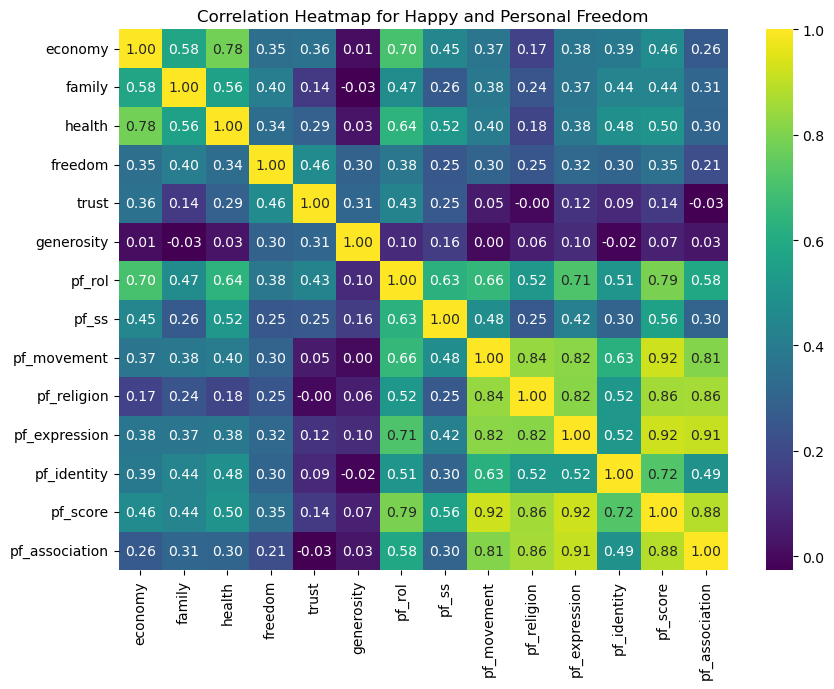

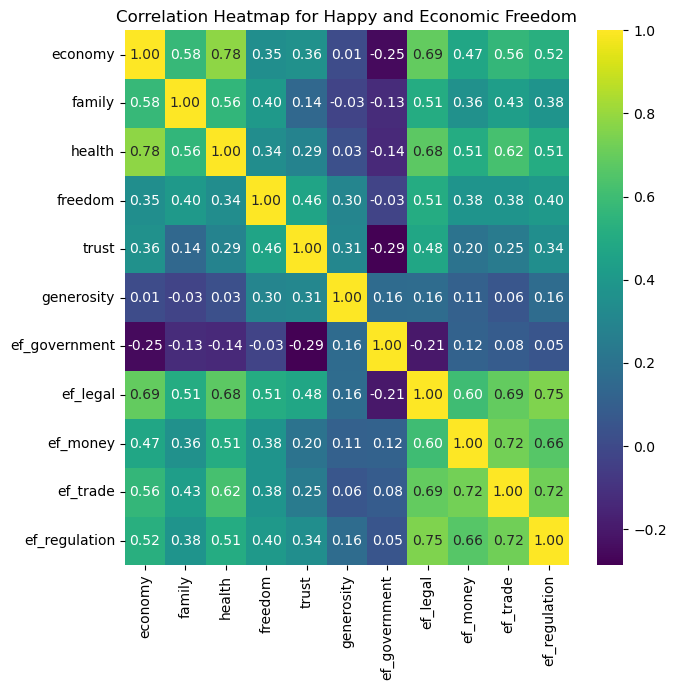

In [34]:
# Grafico della heatmap per happy_pfreedom
plt.figure(figsize=(9, 7))
sns.heatmap(corr_happy_pfreedom, cmap='viridis', annot=True, fmt=".2f")
plt.title('Correlation Heatmap for Happy and Personal Freedom')
#plt.xlabel('Features')
#plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Grafico della heatmap per happy_efreedom
plt.figure(figsize=(7, 7))
sns.heatmap(corr_happy_efreedom, cmap='viridis', annot=True, fmt=".2f")
plt.title('Correlation Heatmap for Happy and Economic Freedom')
#plt.xlabel('Features')
#plt.ylabel('Features')
plt.tight_layout()
plt.show()


<h1>Libertà e Felicità: come vengono percepite nel mondo?</h1>

<h4>Data Transformation</h4>
Finora abbiamo usato il dataframe 'happy_free' come inner join tra i dataframe 'freedom_data' e 'happiness_data', scelta nata dall'esigenza di non avere dati non valorizzati all'interno delle celle rispetto ai grafici finora prodotti.
Durante la prossima fase di esplorazione, la scelta di procedere con con un'unione così stringente della merge non è sembrata ottimale in quanto causerebbe perdita di dati che invece sarebbe comunque interessante osservare visivamente.

Si procede alla trasformazione del dataframe happy_free:

In [35]:
happy_free_outer = pd.merge(happiness_data, freedom_data,  how='outer', left_on=['country','year'], right_on = ['country','year']) 

In [36]:
happy_free_outer[happy_free_outer['country']== 'Russia']

,country,happiness_score,economy,family,health,freedom,trust,generosity,year,region,...,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
63,Russia,5.716,1.137640,1.236170,0.669260,0.366790,0.030050,0.001990,2015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,Russia,5.856,1.232280,1.052610,0.589910,0.326820,0.035860,0.027360,2016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,Russia,5.963,1.281778,1.469282,0.547349,0.373783,0.032963,0.052264,2017,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
529,Russia,5.810,1.151000,1.479000,0.599000,0.399000,0.025000,0.065000,2018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693,Russia,5.648,1.183000,1.452000,0.726000,0.334000,0.031000,0.082000,2019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
columns = happy_free_outer.select_dtypes(include=['float64', 'int64']).columns
columns = columns.drop(['year'])
grouped_by_country = happy_free_outer.groupby('country', as_index=False)[columns].mean()

In [38]:
grouped_by_country = grouped_by_country[['country', 'happiness_score', 'hf_score']]

In [47]:
#tramite la libreria sklearn, vengono normalizzati i dati in modo che in fase di presentazione del grafico, i gap tra stati siano più evidenti
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(happy_free_outer[columns].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=happy_free_outer[columns].columns.values)
df_scaled = pd.concat((df_scaled, grouped_by_country.country), axis=1)

In [48]:
world_merged = world.merge(df_scaled, left_on='name', right_on='country')

# Calcola il centroide di ogni geometria poligonale
world_merged['centroid'] = world_merged['geometry'].centroid

# Estrai le coordinate x e y dal centroide
world_merged['centroid_x'] = world_merged['centroid'].x
world_merged['centroid_y'] = world_merged['centroid'].y

# Aggiungi un offset per spostare i valori sopra lo zero
offset = abs(world_merged['happiness_score'].min()) + 1
world_merged['happiness_score_shifted'] = world_merged['happiness_score'] + offset

# Applica lo StandardScaler
std_scaler = StandardScaler()
world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

# Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 20

/var/folders/w_/dv5r5z3j0xx6g2nks8s390lm0000gn/T/ipykernel_18716/4191958976.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_merged['centroid'] = world_merged['geometry'].centroid


In [42]:
world_merged.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,happiness_score,economy,family,health,...,ef_trade,ef_regulation,ef_score,pf_association,country,centroid,centroid_x,centroid_y,happiness_score_shifted,happiness_score_scaled
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.452619,-0.789938,-0.191635,0.023552,...,0.109633,0.133146,0.054061,0.171037,Fiji,POINT (163.85316 -17.31631),163.853165,-17.316309,3.706936,0.272928
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",-1.698729,-1.704746,-0.925168,-0.740583,...,0.004122,0.910083,0.276127,-1.467892,Tanzania,POINT (34.75299 -6.25773),34.752990,-6.257732,1.555587,-1.714674
2,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1.060570,0.337680,0.515694,0.704471,...,-2.578958,-1.120404,-1.641714,0.809226,Canada,POINT (-98.14238 61.46908),-98.142381,61.469076,4.314887,0.834606
3,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1.735085,1.092200,0.286598,0.880695,...,1.312192,2.014709,1.790212,1.061362,United States of America,POINT (-112.59944 45.70563),-112.599436,45.705628,4.989402,1.457781
4,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",-0.148232,0.264918,-0.426500,0.112974,...,-0.001223,-0.110494,-0.602042,-1.683197,Kazakhstan,POINT (67.28461 48.19166),67.284611,48.191661,3.106085,-0.282190


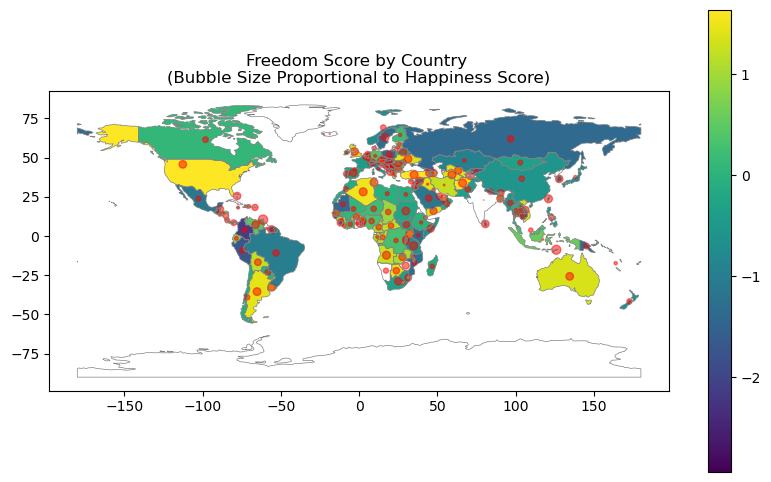

In [49]:
#this command to avoid ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Crea un grafico con geopandas
fig, ax = plt.subplots(figsize=(10, 6))
world_merged.plot(column='hf_score', cmap='viridis', legend=True, ax=ax)

# Aggiungi le bolle colorate in base all'happiness_score
ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
            s=bubble_sizes, color='red', alpha=0.5)

# Aggiungi le linee dei confini degli stati
world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

plt.title('Freedom Score by Country \n(Bubble Size Proportional to Happiness Score)')
plt.show()

In [ ]:
world_merged.hf_score.describe()

In [50]:
happy_free_by_country = happy_free[['country', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('country', as_index=False).mean()

numeric_columns = happy_free_by_country.select_dtypes(include=[np.number])


In [60]:
df_scaled.shape

(153, 45)

In [62]:
happy_free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 544 to 94
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          736 non-null    object 
 1   happiness_score  736 non-null    float64
 2   economy          736 non-null    float64
 3   family           736 non-null    float64
 4   health           736 non-null    float64
 5   freedom          736 non-null    float64
 6   trust            735 non-null    float64
 7   generosity       736 non-null    float64
 8   year             736 non-null    int64  
 9   region           736 non-null    object 
 10  hf_score         736 non-null    float64
 11  pf_rol           736 non-null    float64
 12  pf_ss            736 non-null    float64
 13  pf_movement      736 non-null    float64
 14  pf_religion      736 non-null    float64
 15  pf_expression    736 non-null    float64
 16  pf_identity      736 non-null    float64
 17  pf_score         736

In [54]:
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(numeric_columns.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=numeric_columns.columns.values)
df_scaled = df_scaled.add_suffix('_scaled')
df_scaled = pd.concat((df_scaled, happy_free_by_country), axis=1)

# Unisci i dati geospaziali con i dati aggregati per country
world_merged = world.merge(df_scaled, left_on='name', right_on='country')


# Aggiungi un offset per spostare i valori sopra lo zero dell'happiness_score
offset = abs(world_merged['happiness_score'].min()) + 1
world_merged['happiness_score_shifted'] = world_merged['happiness_score_scaled'] + offset

# Applica lo StandardScaler
world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

# Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 20


# Calcola il centroide di ogni geometria poligonale
world_merged['centroid'] = world_merged['geometry'].centroid

# Estrai le coordinate x e y dal centroide
world_merged['centroid_x'] = world_merged['centroid'].x
world_merged['centroid_y'] = world_merged['centroid'].y

/var/folders/w_/dv5r5z3j0xx6g2nks8s390lm0000gn/T/ipykernel_18716/3320064787.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_merged['centroid'] = world_merged['geometry'].centroid


In [56]:
world_merged[world_merged['country']=='Russia']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,happiness_score_scaled,economy_scaled,family_scaled,health_scaled,...,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association,happiness_score_shifted,centroid,centroid_x,centroid_y


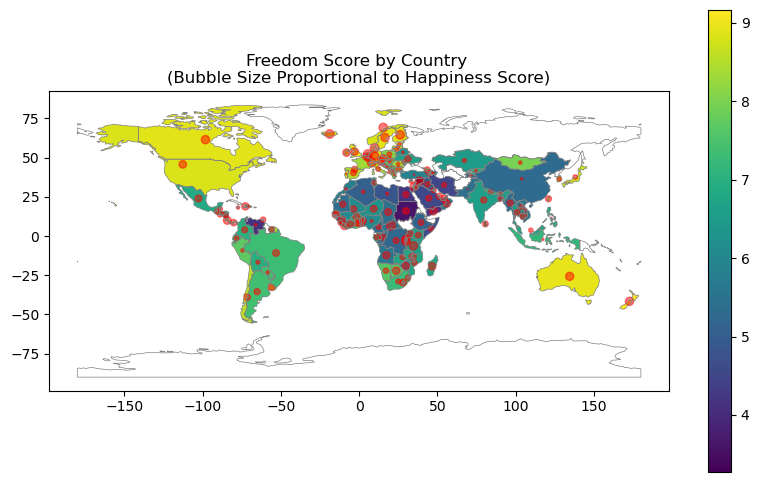

In [55]:
#this command to avoid ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Crea un grafico con geopandas
fig, ax = plt.subplots(figsize=(10, 6))
world_merged.plot(column='hf_score', cmap='viridis', legend=True, ax=ax)

# Aggiungi le bolle colorate in base all'happiness_score
ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
            s=bubble_sizes, color='red', alpha=0.5)

# Aggiungi le linee dei confini degli stati
world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

plt.title('Freedom Score by Country \n(Bubble Size Proportional to Happiness Score)')
plt.show()

In [ ]:
def show_map():
    grouped_year = happy_free[['country', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('country', as_index=False).mean()

    df = grouped_year[['happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']]

    
    std_scaler = StandardScaler()
    
    df_scaled = std_scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns.values)
    df_scaled = pd.concat((df_scaled, grouped_year.country), axis=1)



    # Carica i dati geospaziali
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Unisci i dati geospaziali con i dati aggregati per anno
    world_merged = world.merge(df_scaled, left_on='name', right_on='country')

    # Calcola il centroide di ogni geometria poligonale
    world_merged['centroid'] = world_merged['geometry'].centroid

    # Estrai le coordinate x e y dal centroide
    world_merged['centroid_x'] = world_merged['centroid'].x
    world_merged['centroid_y'] = world_merged['centroid'].y

    # Aggiungi un offset per spostare i valori sopra lo zero
    offset = abs(world_merged['happiness_score'].min()) + 1
    world_merged['happiness_score_shifted'] = world_merged['happiness_score'] + offset

    # Applica lo StandardScaler
    std_scaler = StandardScaler()
    world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

    # Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
    bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 20

    # Crea un grafico con geopandas
    fig, ax = plt.subplots(figsize=(10, 6))
    world_merged.plot(column='happiness_score', cmap='viridis', legend=True, ax=ax)

    # Aggiungi le bolle colorate in base all'happiness_score
    ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
                s=bubble_sizes, color='red', alpha=0.5)

    # Aggiungi le linee dei confini degli stati
    world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

    plt.title('Happiness Score by Country \n(Bubble Size Proportional to Score)')
    plt.show()


In [ ]:
show_map()

In [ ]:
def show_map():
    grouped_year = happy_free[['country', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('country', as_index=False).mean()

    df = grouped_year[['happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']]

    
    std_scaler = StandardScaler()
    
    df_scaled = std_scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns.values)
    df_scaled = pd.concat((df_scaled, grouped_year.country), axis=1)



    # Carica i dati geospaziali
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Unisci i dati geospaziali con i dati aggregati per anno
    world_merged = world.merge(df_scaled, left_on='name', right_on='country')

    # Calcola il centroide di ogni geometria poligonale
    world_merged['centroid'] = world_merged['geometry'].centroid

    # Estrai le coordinate x e y dal centroide
    world_merged['centroid_x'] = world_merged['centroid'].x
    world_merged['centroid_y'] = world_merged['centroid'].y

    # Applica lo StandardScaler per hf_score
    std_scaler = StandardScaler()
    world_merged['hf_score_scaled'] = std_scaler.fit_transform(world_merged[['hf_score']])

    # Crea un grafico con geopandas
    fig, ax = plt.subplots(figsize=(10, 6))
    world_merged.plot(column='happiness_score', cmap='viridis', legend=True, ax=ax)

    # Aggiungi lo scatter plot per happiness_score
    ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
                s=50, c=world_merged['hf_score_scaled'], cmap='coolwarm', alpha=0.8)

    # Aggiungi le linee dei confini degli stati
    world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

    plt.title('Happiness Score by Country \n(Color by HF Score)')
    plt.show()

show_map()


<h2>Analisi per continente</h2>

In [170]:
world_happy_free = happy_free.merge(world, left_on="country", right_on="name")

In [173]:
type(world_happy_free)

pandas.core.frame.DataFrame

In [176]:
happy_free_by_continents = world_happy_free.groupby('continent')[['happiness_score', 'hf_score']].mean().reset_index()

In [178]:
happy_free_by_continents.sort_values('hf_score', ascending=False)

,continent,happiness_score,hf_score
4,Oceania,7.294600,9.035000
2,Europe,6.159228,8.311304
3,North America,6.099500,7.664853
5,South America,6.126635,7.210192
1,Asia,5.261165,6.450825
0,Africa,4.259495,6.150545


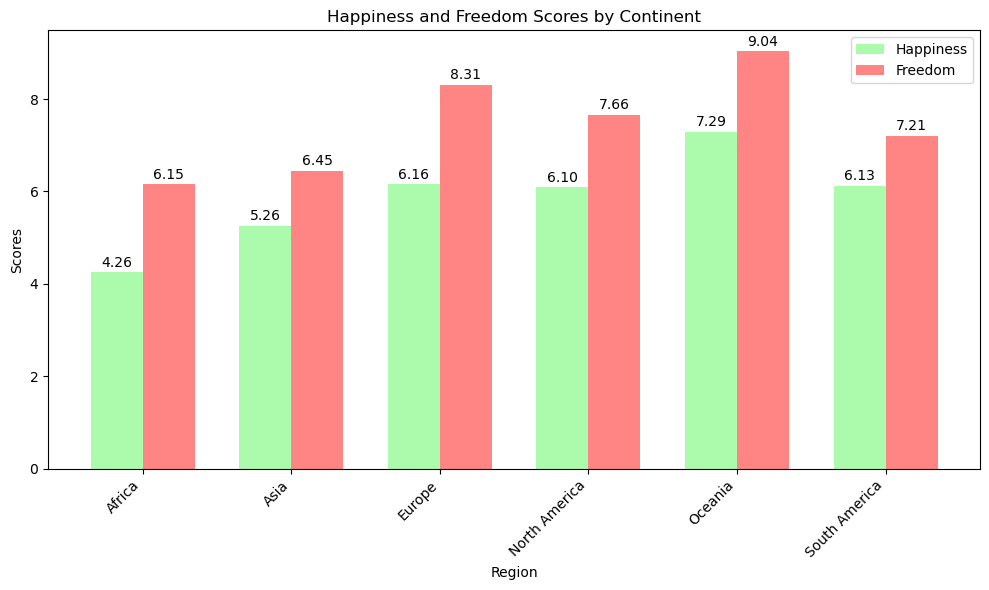

In [180]:
# Dati
continent = happy_free_by_continents['continent'].unique()
happiness_score_by_region = happy_free_by_continents.groupby('continent')['happiness_score'].mean()
freedom_score_by_region = happy_free_by_continents.groupby('continent')['hf_score'].mean()

# Impostazioni grafiche
bar_width = 0.35
opacity = 0.8
index = range(len(continent))

# Colori personalizzati
happiness_color = '#98FB98'
freedom_color = '#FF6666'

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, happiness_score_by_region, bar_width, alpha=opacity, color=happiness_color, label='Happiness')
bars2 = plt.bar([i + bar_width for i in index], freedom_score_by_region, bar_width, alpha=opacity, color=freedom_color, label='Freedom')

# Altezza aggiuntiva per il testo
text_height = 0.05

# Aggiungi il valore di happiness_score su ogni barra
for bar, value in zip(bars1, happiness_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Aggiungi il valore di hf_score su ogni barra
for bar, value in zip(bars2, freedom_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Impostazioni sull'asse x
plt.xlabel('Region')
plt.ylabel('Scores')
plt.title('Happiness and Freedom Scores by Continent')
plt.xticks([i + bar_width/2 for i in index], continent, rotation=45, ha='right')  # Impostazione della posizione allineata al centro con rotazione

# Aggiunta di una legenda
plt.legend()

# Visualizzazione del grafico
plt.tight_layout()
plt.show()


<h2>Analisi per regione mondiale</h2>

In [143]:
happy_free_by_region = happy_free[['region', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('region', as_index=False).mean()

In [157]:
happy_free_by_region[['region', 'happiness_score', 'hf_score']].sort_values('hf_score', ascending=False)

,region,happiness_score,hf_score
6,Oceania,7.294600,9.035000
5,North America,7.174700,8.860000
9,Western Europe,6.938967,8.750222
2,Eastern Europe,5.494991,7.973486
1,East Asia,5.651567,7.931667
3,Latin America & the Caribbean,6.014582,7.341273
0,Caucasus & Central Asia,5.011800,6.779000
7,South Asia,5.101473,6.423784
8,Sub-Saharan Africa,4.181541,6.321585
4,Middle East & North Africa,5.377911,5.437000


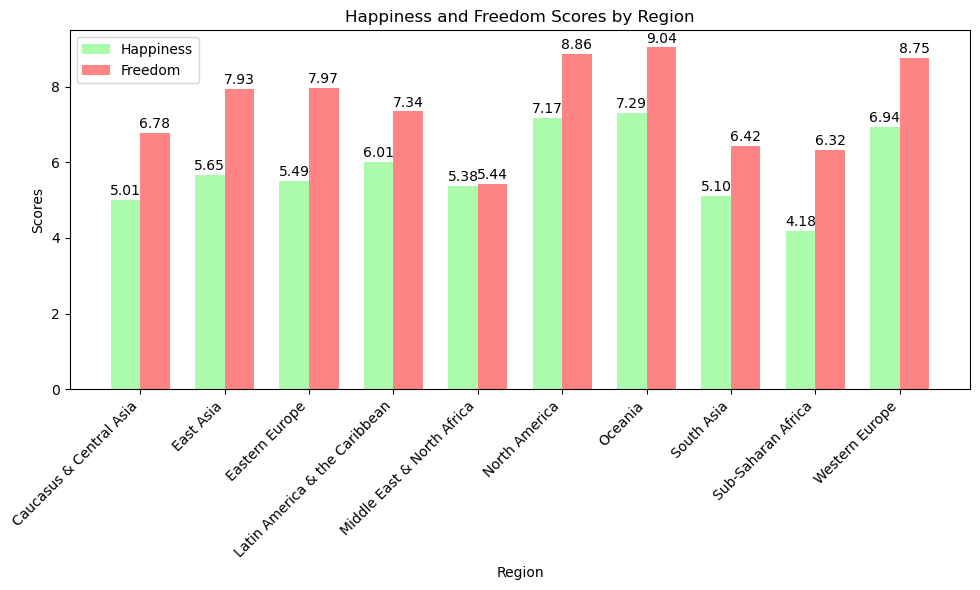

In [159]:
# Dati
region = happy_free_by_region['region'].unique()
happiness_score_by_region = happy_free_by_region.groupby('region')['happiness_score'].mean()
freedom_score_by_region = happy_free_by_region.groupby('region')['hf_score'].mean()

# Impostazioni grafiche
bar_width = 0.35
opacity = 0.8
index = range(len(region))

# Colori personalizzati
happiness_color = '#98FB98'
freedom_color = '#FF6666'

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, happiness_score_by_region, bar_width, alpha=opacity, color=happiness_color, label='Happiness')
bars2 = plt.bar([i + bar_width for i in index], freedom_score_by_region, bar_width, alpha=opacity, color=freedom_color, label='Freedom')

# Altezza aggiuntiva per il testo
text_height = 0.05

# Aggiungi il valore di happiness_score su ogni barra
for bar, value in zip(bars1, happiness_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Aggiungi il valore di hf_score su ogni barra
for bar, value in zip(bars2, freedom_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Impostazioni sull'asse x
plt.xlabel('Region')
plt.ylabel('Scores')
plt.title('Happiness and Freedom Scores by Region')
plt.xticks([i + bar_width/2 for i in index], region, rotation=45, ha='right')  # Impostazione della posizione allineata al centro con rotazione

# Aggiunta di una legenda
plt.legend()

# Visualizzazione del grafico
plt.tight_layout()
plt.show()


<h2>Serie storica</h2>

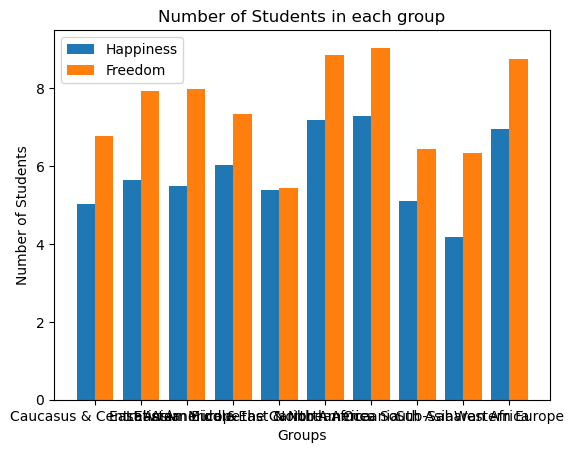

In [144]:
region = happy_free_by_region.region.unique()
happiness_score_by_region = happy_free_by_region.happiness_score
freedom_score_by_region = happy_free_by_region.hf_score

X_axis = np.arange(len(region)) 
  
plt.bar(X_axis - 0.2, happiness_score_by_region, 0.4, label = 'Happiness') 
plt.bar(X_axis + 0.2, freedom_score_by_region, 0.4, label = 'Freedom') 
  
plt.xticks(X_axis, region) 
plt.xlabel("Groups") 
plt.ylabel("Number of Students") 
plt.title("Number of Students in each group") 
plt.legend() 
plt.show() 

In [121]:
world_happy_free = happy_free.merge(world, left_on='country', right_on='name', how='left')

In [117]:
# 1. Calcolare la media di hf_score e happiness_score per regione
region_means = world_happy_free.groupby('region')[['hf_score', 'happiness_score']].mean()

In [123]:
# 2. Unire le medie con il dataframe world_happy_free sulla colonna region
world_happy_free = world_happy_free.merge(region_means, on='region', suffixes=('', '_mean'))


In [89]:

'''
# 2. Unire le medie con il dataframe world_happy_free sulla colonna region
world_happy_free = world_happy_free.merge(region_means, on='region')

# 3. Calcolare i centroidi delle regioni
region_centroids = world_happy_free.groupby('region').agg({'geometry': 'centroid'})

# 4. Creare una mappa usando Geopandas
fig, ax = plt.subplots(figsize=(10, 6))

# Plot della mappa usando Geopandas
world_happy_free.plot(column='hf_score', cmap='coolwarm', legend=True, ax=ax)

# Plot degli happiness_score come scatterplot rispetto alla media per regione
for region, centroid in region_centroids['geometry'].items():
    ax.scatter(centroid.x, centroid.y, s=region_means.loc[region, 'happiness_score'] * 100, c='black', marker='o', label=region)

plt.title('Happiness Score by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Region')
plt.show()
'''


"\nregion_means = world_happy_free.groupby('region')[['hf_score', 'happiness_score']].mean()\nregion_means = world_happy_free.groupby('region').agg({'hf_score': 'mean', 'happiness_score': 'mean'})\n\n\n# 2. Unire le medie con il dataframe world_happy_free sulla colonna region\nworld_happy_free = world_happy_free.merge(region_means, on='region')\n\n# 3. Calcolare i centroidi delle regioni\nregion_centroids = world_happy_free.groupby('region').agg({'geometry': 'centroid'})\n\n# 4. Creare una mappa usando Geopandas\nfig, ax = plt.subplots(figsize=(10, 6))\n\n# Plot della mappa usando Geopandas\nworld_happy_free.plot(column='hf_score', cmap='coolwarm', legend=True, ax=ax)\n\n# Plot degli happiness_score come scatterplot rispetto alla media per regione\nfor region, centroid in region_centroids['geometry'].items():\n    ax.scatter(centroid.x, centroid.y, s=region_means.loc[region, 'happiness_score'] * 100, c='black', marker='o', label=region)\n\nplt.title('Happiness Score by Region')\nplt.xl

In [75]:
#region = happy_free.region.unique()
happy_free.region.unique()

array(['Eastern Europe', 'Middle East & North Africa',
       'Sub-Saharan Africa', 'Latin America & the Caribbean',
       'Caucasus & Central Asia', 'Oceania', 'Western Europe',
       'South Asia', 'North America', 'East Asia'], dtype=object)

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Creare un DataFrame per i centroidi delle regioni
region_centroids = happy_free_by_region.groupby('region')[['centroid_x', 'centroid_y']].mean()

# Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
bubble_sizes = np.abs(happy_free_by_region['happiness_score']) * 20

# Crea un grafico con geopandas
fig, ax = plt.subplots(figsize=(10, 6))

# Itera su ciascuna regione e aggiungi il suo scatterplot corrispondente
for region, data in happy_free_by_region.groupby('region'):
    # Utilizza il centroide medio come punto della regione
    region_centroid = region_centroids.loc[region]
    # Aggiungi i punti colorati in base all'happiness_score
    ax.scatter(region_centroid['centroid_x'], region_centroid['centroid_y'], s=bubble_sizes.loc[data.index], label=region)
    
# Aggiungi le linee dei confini degli stati
world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Aggiungi una legenda
plt.legend(title='Region')
plt.title('Happiness Score by Region \n(Bubble Size Proportional to Score)')
plt.show()


KeyError: "Columns not found: 'centroid_y', 'centroid_x'"

In [67]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [66]:
happy_free_by_region.head(10)

,region,happiness_score,economy,family,health,freedom,trust,generosity,hf_score,pf_rol,...,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
0,Caucasus & Central Asia,5.011800,0.828944,1.000230,0.640377,0.378848,0.124503,0.151008,6.779000,4.796798,...,4.734688,8.833333,6.498333,6.988696,5.466639,8.638576,7.436826,7.323614,7.171667,5.331355
1,East Asia,5.651567,1.237695,1.199232,0.862612,0.418185,0.117992,0.199801,7.931667,6.729239,...,7.155890,9.604167,8.091000,6.809159,6.732475,9.375693,7.832961,7.803619,7.710333,7.251586
2,Eastern Europe,5.494991,1.112914,1.183093,0.759721,0.322979,0.051618,0.148268,7.973486,6.078481,...,7.320249,9.375000,8.358991,6.665091,5.980160,8.846328,8.093188,7.580169,7.433119,8.433820
3,Latin America & the Caribbean,6.014582,0.937863,1.187996,0.675151,0.464295,0.092157,0.185045,7.341273,4.470298,...,7.180506,8.895833,7.649727,7.440869,4.794030,8.457511,7.372889,6.485970,6.910000,8.134726
4,Middle East & North Africa,5.377911,1.128701,0.992137,0.669151,0.358945,0.147633,0.182306,5.437000,4.410148,...,3.591841,3.692722,4.839333,6.205675,4.382252,8.163537,6.290992,6.324986,6.273778,4.256922
5,North America,7.174700,1.422037,1.357991,0.861086,0.558918,0.223345,0.372339,8.860000,7.235509,...,9.697148,10.000000,9.302000,6.933826,7.950291,9.683543,7.857954,8.786969,8.243000,9.496271
6,Oceania,7.294600,1.356197,1.424368,0.903074,0.611413,0.357294,0.424441,9.035000,7.781751,...,9.626285,10.000000,9.479000,6.722093,8.550213,9.600537,8.331097,8.875856,8.417000,9.582896
7,South Asia,5.101473,0.809187,1.002798,0.603303,0.501142,0.124489,0.352663,6.423784,4.297976,...,4.993459,6.292230,6.146081,7.714513,4.897904,7.915728,6.535484,7.000687,6.812838,5.630500
8,Sub-Saharan Africa,4.181541,0.461508,0.859585,0.286005,0.356292,0.097676,0.203109,6.321585,4.243087,...,5.766904,5.520497,6.417596,6.809374,4.256551,7.422902,5.958692,6.484427,6.186503,6.647459
9,Western Europe,6.938967,1.390221,1.382223,0.893397,0.550279,0.246430,0.288603,8.750222,7.901704,...,9.318084,9.805556,9.352444,5.821586,7.883669,9.459056,8.400269,7.975075,7.907667,9.421931


In [ ]:
print('pippo')